In [1]:
import time

import numpy as np
from skimage.io import imread, imsave
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from matplotlib import pyplot as plt

In [2]:
class LBG:
    def __init__(self, n_clusters, epsilon=0.00001):
        self.n_clusters=n_clusters
        self.epsilon=epsilon

    def _get_init_cb(self, data):
        return np.array([np.mean(data, axis=0)])

    def _create_codebook(self, data, e):
        return data * (1.0 + e)

    def _average_distortion(self, data, codebook, idx):
        return np.mean([np.linalg.norm(data - codebook[i], axis=1) ** 2 for i in idx])

    def _split_codebook(self, data, codebook, init_distortion):
        tmp_cbs = np.empty((0, self.n_features))
        for i in range(2):
            tmp_cbs = np.append(tmp_cbs, self._create_codebook(codebook, (-1)**i * self.epsilon), axis=0)

        codebook = np.copy(tmp_cbs)
        distortion = init_distortion
        err = 1.0 + self.epsilon;

        while err > self.epsilon:
            norms = np.array([np.linalg.norm(data - c, axis=1)**2 for c in codebook])
            idx_min = np.argmin(norms, axis=0)
            idx_map = np.zeros((self.N, len(codebook)))
            idx_map[range(len(data)), idx_min] = 1

            s = (np.sum(idx_map, axis=0, dtype=float)+1e-16).reshape(len(codebook), -1)
            codebook = np.dot(idx_map.T, data) / s

            prev_distortion = distortion
            distortion = self._average_distortion(data, codebook, idx_min)
            err = (prev_distortion - distortion) / distortion

        return codebook, idx_min

    def fit(self, data):
        shape = data.shape
        self.N = shape[0]
        self.n_features=shape[1]
        
        codebook = self._get_init_cb(data)
        distortion = self._average_distortion(data, codebook, np.array([[0]]))

        while len(codebook) < self.n_clusters:
            codebook, labels = self._split_codebook(data, codebook, distortion)
            
        self.cluster_centers_=codebook

        return labels

    def predict(self, data):
        norms = np.array([np.linalg.norm(data - c, axis=1)**2 for c in self.cluster_centers_])
        return np.argmin(norms, axis=0)

In [3]:
def get_model(model, n_clusters):
    if (model == "kmeans"):
        return KMeans(n_clusters=n_clusters, n_jobs=-1)
    if (model == "lbg"):
        return LBG(n_clusters=n_clusters)

def im_compress(img_path, n_clusters=64, model="lbg", n_random=1000, debug=False):
    img = imread(img_path)
    rows, cols, depth = img.shape
    if debug:
        print("Img info\n\tw:{} h:{} d:{}", cols, rows, depth)

    img_vect = img.reshape(rows * cols, depth)
    # take n random pixels
    img_train = shuffle(img_vect)[:n_random]

    model = get_model(model, n_clusters)

    start = time.time()

    # train k-means using only n random pixels
    model.fit(img_train)
    labels = model.predict(img_vect)
    labels = labels.reshape(rows, cols)

    end = time.time()

    if debug:
        print('Total time: %.2f' % (end - start))
        print('centers: ', model.cluster_centers_)
        print('labels: ', labels)

    np.save('cmprs_cntrs.npy', model.cluster_centers_)
    imsave('cmprs_lbls.png', labels)

    return 'cmprs_cntrs.npy', 'cmprs_lbls.png'

def im_decompress(centers, labels, debug=False):
    centers = np.load(centers)
    labels = imread(labels)

    if debug:
        print('centers: ', centers)
        print('labels: ', labels)

    image = np.zeros((labels.shape[0], labels.shape[1], centers.shape[1]), dtype=np.uint8)
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            image[i, j, :] = centers[labels[i, j], :]

    imsave('reconstructed.png', image)
    

In [13]:
img = 'face.png'
cluster_count = np.arange(15, 128, 1)
n_clusters=64

original_img = imread(img)
h, w, d = original_img.shape

models=["lbg", "kmeans"]

centers, labels = im_compress(img, n_clusters=n_clusters, model=models[1])
im_decompress(centers, labels)

/usr/local/lib/python3.5/dist-packages/skimage/io/_io.py:132: UserWarning: cmprs_lbls.png is a low contrast image
  warn('%s is a low contrast image' % fname)


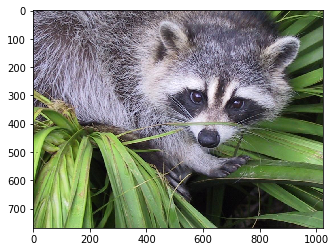

In [14]:
plt.imshow(original_img)
plt.show()

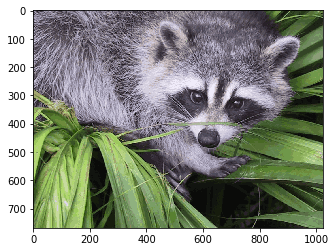

In [15]:
reconstrucred_img=imread('reconstructed.png')
plt.imshow(reconstrucred_img)
plt.show()